In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/mcdonalds.csv')

# Inspect the dataset
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())


  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male  
(1453, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  --

In [5]:
# Handle missing values in 'Like' and 'Age' columns
df['Like'] = df['Like'].replace({'I love it!+5': 5, 'I hate it!-5': -5})
df['Like'] = pd.to_numeric(df['Like'], errors='coerce')
df['Like'].fillna(df['Like'].mean(), inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)

# Drop unnecessary columns (like 'Gender' or any other non-numeric columns)
df.drop(columns=['Gender'], axis=1, inplace=True)

# Encode categorical columns
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Standardize the dataset
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)


In [6]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2"])
print(pca_df.head())


       PCA1      PCA2
0  1.348359 -1.035403
1 -0.722354  0.911410
2  0.140645  0.789842
3 -0.374337 -0.737845
4  0.006629 -1.424720


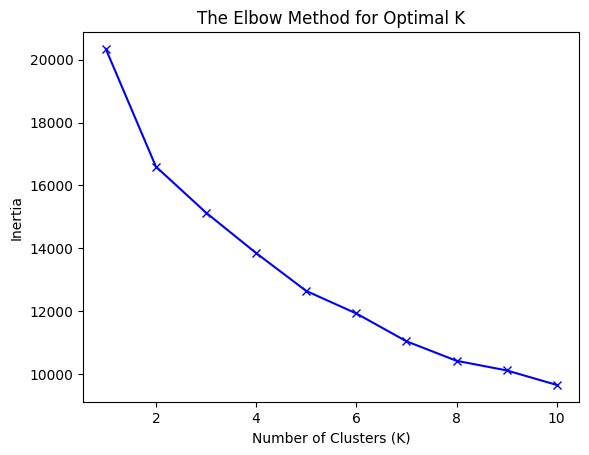

In [7]:
# Find optimal K using Elbow Method
inertia = []
for i in range(1, 11):
    kmean = KMeans(n_clusters=i, random_state=42)
    kmean.fit(scaled_df)
    inertia.append(kmean.inertia_)

# Plot inertia values
plt.plot(range(1, 11), inertia, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('The Elbow Method for Optimal K')
plt.show()

# Fit KMeans with the chosen number of clusters
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(scaled_df)
df['Cluster'] = kmeans_model.labels_


In [8]:
# Split the data
X = df.drop(['Cluster'], axis=1)
y = df['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree classifier
model = DecisionTreeClassifier()

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.94
Confusion Matrix:
[[ 47   0   2   0]
 [  0 156   3   0]
 [  3   9 114   5]
 [  1   3   2  91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        49
           1       0.93      0.98      0.95       159
           2       0.94      0.87      0.90       131
           3       0.95      0.94      0.94        97

    accuracy                           0.94       436
   macro avg       0.94      0.94      0.94       436
weighted avg       0.94      0.94      0.94       436



In [9]:
import pickle

# Save the model
filename = 'optimized_decision_tree_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

# Load the model from the file
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Evaluate the loaded model
loaded_model_accuracy = loaded_model.score(X_test, y_test)
print(f'Loaded Model Accuracy: {loaded_model_accuracy * 100:.2f}%')


Loaded Model Accuracy: 93.58%
